## Universal Differential Equation

**Steps**

1. Initial Condition and Experimentation
2. Neural Network for Unknown Term
3. Combine with the known Ordinary Differential Equation
4. Numerical Integration
5. Compare predictions to experimental data
6. Backpropagation and optimization
7. Final Model

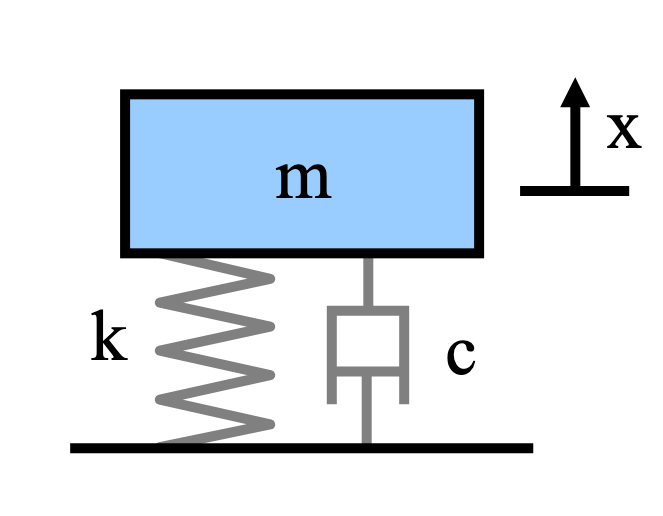

In [1]:
# Install torchdiffeq
!pip install torchdiffeq

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp # Numerically solve ivp
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint # Odesolvers

%matplotlib inline

We will simulate a classical damped spring mass system with ODE.
\begin{align*}
m \frac{d^2 x}{dt^2} + c\frac{dx}{dt} + kx = 0,
\end{align*}
We us `scipy.integrate.solve_ivp` to generate the solution, then add noise.

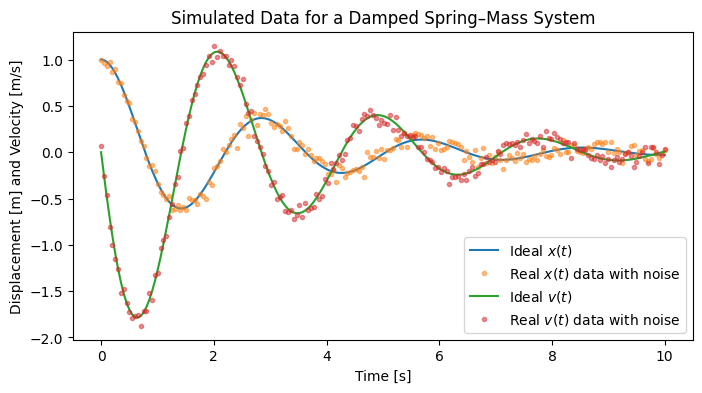

In [3]:
# Physical Paramters
m = 1.0  # Mass
k = 5.0  # Spring constant

c_true = 0.7 # True damping constant

def damped_spring_mass(t, y):
  """
  Classical ODE for damped spring mass system:
    y = [x, dx/dt]
    dy/dt = [dx/dt, -(c/m)*dx/dt - (k/m)*x]
    x_dot = dx/dt
    x_ddot = -(c/m)*dx/dt - (k/m)*x
  """
  x, x_dot = y
  x_ddot = -(c_true/m)*x_dot - (k/m)*x
  return [x_dot, x_ddot]

# Initial conditions
x0 = 1.0 # initial displacement
v0 = 0.0 # initial velocity x_dot
y0 = [x0, v0]

# Time points
t_start, t_end = 0.0, 10.0
t = np.linspace(t_start, t_end, 200) # 200 data points

# Solve the classical ODE
sol = solve_ivp(damped_spring_mass, [t_start, t_end], y0, t_eval=t)
x_true = sol.y[0, :] # x(t)
v_true = sol.y[1, :] # x_dot(t)

# Add noise to simulate experimental data
noise_level = 0.05
x_noisy = x_true + noise_level * np.random.randn(len(x_true))
v_noisy = v_true + noise_level * np.random.randn(len(v_true))

# Plot the noisy vs. true solution
plt.figure(figsize=(8, 4))
plt.plot(t, x_true, label='Ideal $x(t)$')
plt.plot(t, x_noisy, 'o', label='Real $x(t)$ data with noise', alpha=0.5, markersize=3)
plt.plot(t, v_true, label='Ideal $v(t)$')
plt.plot(t, v_noisy, 'o', label='Real $v(t)$ data with noise', alpha=0.5, markersize=3)
plt.title("Simulated Data for a Damped Spring–Mass System")
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m] and Velocity [m/s]')
plt.legend()
plt.show()

In [4]:
# Define the Neural Network
class DampeningNeuralNetwork(nn.Module):
  """
  - current displacement u1,
  - current velocity u2,
  - optionally time t, outputs an estimate of the damping force
  """
  def __init__(self, input_size=2, hidden_size=16):
    super(DampeningNeuralNetwork, self).__init__()
    self.net = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, 1)
    )
  def forward(self, t, u):
    # u is (batch_size, 2) - > [x, x_dot]
    # t is a scalar or shape (batch_size, )
    return self.net(u)

Hence, the overall ODE is:
\begin{align*}
u_1' &= u_2,\\
u_2' &= - \frac{k}{m} u_1 \; - \frac{1}{m}\,\underbrace{\mathrm{NN}(u_1, u_2)}_{\text{unknown damping}}.
\end{align*}

In [5]:
# Combine the NN with physics equation
class SpringMassUDE(nn.Module):
  def __init__(self, m, k, dampening_nn):
    """
      Velocity du1/dt = u2
      Acceleration du2/dt = -(c/m)*u2 - (k/m)*u1
    """
    super(SpringMassUDE, self).__init__()
    self.m = m
    self.k = k
    self.dampening_nn = dampening_nn

  def forward(self, t, y):
    """
    y: [u1, u2]
    returns dy/dt
    """
    u1, u2 = y[..., 0], y[..., 1]
    u_cat = torch.stack([u1, u2], dim=-1)
    dampening_force = self.dampening_nn(t, u_cat)
    dampening_force = dampening_force.squeeze(-1)
    du1dt = u2
    du2dt = -(self.k/self.m)*u1 - (dampening_force/self.m)
    return torch.stack([du1dt, du2dt], dim=-1)

In [6]:
# Convert numpy to torch tensor
t_train_torch = torch.tensor(t, dtype=torch.float32)
x_train_torch = torch.tensor(x_noisy, dtype=torch.float32)
v_train_torch = torch.tensor(v_noisy, dtype=torch.float32)

print("Time tensor shape:", t_train_torch.shape)
print("Displacement tensor shape:", x_train_torch.shape)
print("Velocity tensor shape:", v_train_torch.shape)

Time tensor shape: torch.Size([200])
Displacement tensor shape: torch.Size([200])
Velocity tensor shape: torch.Size([200])


In [7]:
# Numerical Integration to get extimated pos and vel
def forward_sim(net_ode, y0, t_points):
  y0_torch = y0.unsqueeze(0) # Creating batch dim of 1 since no batch exists (1,2) 2 for (pos,vel)
  sol = odeint(net_ode, y0_torch, t_points, method='rk4')
  return sol[:,0,:] # Remove batch dim

In [8]:
hidden_dim = 16
dampening_nn = DampeningNeuralNetwork(input_size=2, hidden_size=hidden_dim)
ude = SpringMassUDE(m, k, dampening_nn)
y0_torch = torch.tensor([x_noisy[0], v_noisy[0]], dtype=torch.float32) # Initial Conditions
optimizer = optim.Adam(ude.parameters(), lr=0.01) # Define optimizer
print(dampening_nn)
for name, param in ude.named_parameters():
  print(name, param.shape)

DampeningNeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)
dampening_nn.net.0.weight torch.Size([16, 2])
dampening_nn.net.0.bias torch.Size([16])
dampening_nn.net.2.weight torch.Size([16, 16])
dampening_nn.net.2.bias torch.Size([16])
dampening_nn.net.4.weight torch.Size([1, 16])
dampening_nn.net.4.bias torch.Size([1])


In [9]:
# Training Loop
num_epochs = 100
loss_history = []
print_interval = 1
for epoch in range(num_epochs):
  optimizer.zero_grad()
  sol_pred = forward_sim(ude, y0_torch, t_train_torch)
  x_pred = sol_pred[:,0]
  v_pred = sol_pred[:,1]
  loss = 0.5*torch.mean((x_pred - x_train_torch)**2) + 0.5*torch.mean((v_pred - v_train_torch)**2)
  loss.backward()
  optimizer.step()
  loss_history.append(loss.item())
  if (epoch+1) % print_interval == 0:
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/100], Loss: 0.9975
Epoch [2/100], Loss: 0.4569
Epoch [3/100], Loss: 0.1927
Epoch [4/100], Loss: 0.0764
Epoch [5/100], Loss: 0.0278
Epoch [6/100], Loss: 0.0091
Epoch [7/100], Loss: 0.0035
Epoch [8/100], Loss: 0.0038
Epoch [9/100], Loss: 0.0066
Epoch [10/100], Loss: 0.0103
Epoch [11/100], Loss: 0.0141
Epoch [12/100], Loss: 0.0176
Epoch [13/100], Loss: 0.0208
Epoch [14/100], Loss: 0.0234
Epoch [15/100], Loss: 0.0256
Epoch [16/100], Loss: 0.0273
Epoch [17/100], Loss: 0.0286
Epoch [18/100], Loss: 0.0294
Epoch [19/100], Loss: 0.0299
Epoch [20/100], Loss: 0.0301
Epoch [21/100], Loss: 0.0300
Epoch [22/100], Loss: 0.0296
Epoch [23/100], Loss: 0.0290
Epoch [24/100], Loss: 0.0282
Epoch [25/100], Loss: 0.0272
Epoch [26/100], Loss: 0.0260
Epoch [27/100], Loss: 0.0248
Epoch [28/100], Loss: 0.0234
Epoch [29/100], Loss: 0.0220
Epoch [30/100], Loss: 0.0205
Epoch [31/100], Loss: 0.0189
Epoch [32/100], Loss: 0.0174
Epoch [33/100], Loss: 0.0159
Epoch [34/100], Loss: 0.0144
Epoch [35/100], Loss: 0

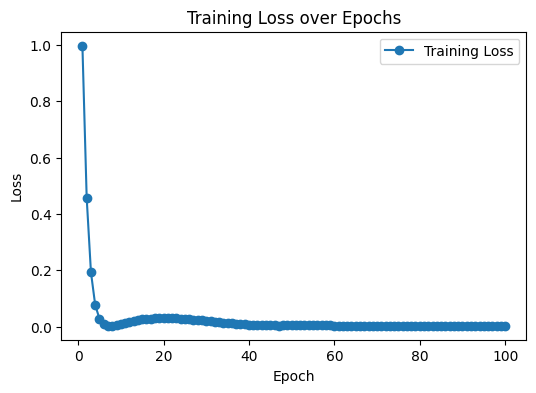

In [10]:
# Plot loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs+1), loss_history, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

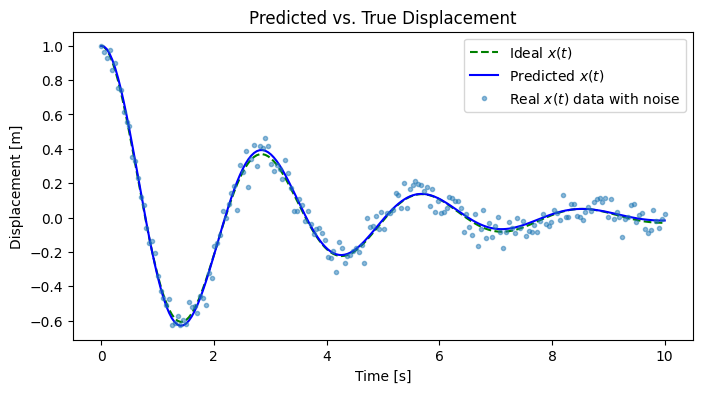

In [11]:
# Plot predicted result
sol_final = forward_sim(ude, y0_torch, t_train_torch).detach().numpy()
x_final = sol_final[:, 0]
v_final = sol_final[:, 1]

plt.figure(figsize=(8, 4))
plt.plot(t, x_true, 'g--', label='Ideal $x(t)$')
plt.plot(t, x_final, 'b-', label='Predicted $x(t)$')
plt.plot(t, x_noisy, 'o', label='Real $x(t)$ data with noise', alpha=0.5, markersize=3)
plt.title("Predicted vs. True Displacement")
plt.xlabel('Time [s]')
plt.ylabel('Displacement [m]')
plt.legend()
plt.show()